## Run the recipe

Now ready to run the recipe!   
We use the most simplest recipe `egs/an4/tts1` as an example.  
> Unfortunately, `egs/an4/tts1` is too small to generate reasonable speech.   
> But you can understand the flow or TTS recipe through this recipe since all of the TTS recipes has the exactly same flow.


In [1]:
# Let's go to an4 recipe!
import os
os.chdir("espnet/egs/an4/tts1")

Before running the recipe, let us check the recipe structure.

In [2]:
!tree -L 1

.
├── cmd.sh
├── conf
├── data
├── downloads
├── dump
├── exp
├── local -> ../asr1/local
├── path.sh
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

8 directories, 3 files


Each recipe has the same structure and files.  

- **run.sh**: Main script of the recipe. Once you run this script, all of the processing will be conducted from data download, preparation, feature extraction, training, and decoding.
- **cmd.sh**: Command configuration source file about how-to-run each processing. You can modify this script if you want to run the script through job control system e.g. Slurm or Torque.
- **path.sh**: Path configuration source file. Basically, we do not have to touch.
- **conf/**: Directory containing configuration files.
- **local/**: Directory containing the recipe-specific scripts e.g. data preparation.
- **steps/** and **utils/**: Directory containing kaldi tools.

Main script **run.sh** consists of several stages:

- **stage -1**: Download data if the data is available online.
- **stage 0**: Prepare data to make kaldi-stype data directory.
- **stage 1**: Extract feature vector, calculate statistics, and perform normalization.
- **stage 2**: Prepare a dictionary and make json files for training.
- **stage 3**: Train the E2E-TTS network.
- **stage 4**: Decode mel-spectrogram using the trained network.
- **stage 5**: Generate a waveform from a generated mel-spectrogram using Griffin-Lim.

Currently, we support the following networks:
- Tacotron2: [Natural TTS Synthesis by Conditioning WaveNet on Mel Spectrogram Predictions](https://arxiv.org/abs/1712.05884)
- Transformer: [Neural Speech Synthesis with Transformer Network](https://arxiv.org/pdf/1809.08895.pdf)
- FastSpeech: [FastSpeech: Fast, Robust and Controllable Text to Speech](https://arxiv.org/pdf/1905.09263.pdf)

Let us check each stage step-by-step via **--stage** and **--stop_stage** options!


### Stage -1: Data download

This stage downloads dataset if the dataset is available online.

In [3]:
!./run.sh --stage -1 --stop_stage -1

stage -1: Data Download
local/download_and_untar.sh: an4 directory already exists in ./downloads
dictionary: data/lang_1char/train_nodev_units.txt


In [4]:
!tree -L 1
!ls downloads/

.
├── cmd.sh
├── conf
├── data
├── downloads
├── dump
├── exp
├── local -> ../asr1/local
├── path.sh
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

8 directories, 3 files
an4  an4_sphere.tar.gz


You can see **downloads** directory is cretead, which containing donwloaded an4 dataset.

### Stage 0: Data preparation

This stage creates kaldi-style data directories.

In [5]:
!./run.sh --stage 0 --stop_stage 0

stage 0: Data preparation
dictionary: data/lang_1char/train_nodev_units.txt


In [6]:
!tree -L 1 data

data
├── test
└── train

2 directories, 0 files


Through the data preparation stage, kaldi-style data directories will be created.  
Here, **data/train/** is corresponding to training set,  and **data/test** is corresponding to evaluation set.  
Each directory has the same following files:

In [7]:
!ls data/*

data/test:
spk2utt  text  utt2spk	wav.scp

data/train:
spk2utt  text  utt2spk	wav.scp


The above four files are all we have to prepare to create new recipes.  
Let's check each file.

In [8]:
!head -n 3 data/train/{wav.scp,text,utt2spk,spk2utt}

==> data/train/wav.scp <==
fash-an251-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an251-fash-b.sph |
fash-an253-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an253-fash-b.sph |
fash-an254-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an254-fash-b.sph |

==> data/train/text <==
fash-an251-b YES
fash-an253-b GO
fash-an254-b YES

==> data/train/utt2spk <==
fash-an251-b fash
fash-an253-b fash
fash-an254-b fash

==> data/train/spk2utt <==
fash fash-an251-b fash-an253-b fash-an254-b fash-an255-b fash-cen1-b fash-cen2-b fash-cen4-b fash-cen5-b fash-cen7-b
fbbh fbbh-an86-b fbbh-an87-b fbbh-an88-b fbbh-an89-b fbbh-an90-b fbbh-cen1-b fbbh-cen2-b fbbh-cen3-b fbbh-cen4-b fbbh-cen5-b fbbh-cen6

Each file contains the following information:
- **wav.scp**: List of audio path. Each line has `<utt_id> <wavfile_path or command pipe>`. `<utt_id>` must be unique.
- **text**: List of transcriptions. Each line has `<utt_id> <transcription>`. In the case of TTS, we assume that `<transcription>` is cleaned.
- **utt2spk**: List of correspondence table between utterances and speakers. Each line has `<utt_id> <speaker_id>`.
- **spk2utt**: List of correspondence table between speakers and utterances. Each lien has `<speaker_id> <utt_id> ... <utt_id> `. This file can be automatically created from **utt2spk**. 

In the ESPnet, speaker information is not used for any processing.   
Therefore, **utt2spk** and **spk2utt** can be a dummy.

### Stage 1: Feature extration

This stage performs the following processing:
1. Mel-spectrogram extraction
2. Data split into training and validation set
2. Statistics (mean and variance) calculation
3. Normalization

In [9]:
!./run.sh --stage 1 --stop_stage 1 --nj 4

stage 1: Feature Generation
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/make_fbank.sh --cmd run.pl --nj 4 --fs 16000 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/train exp/make_fbank/train fbank
utils/validate_data_dir.sh: Successfully validated data-directory data/train
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/make_fbank.sh: [info]: no segments file exists: assuming pcm.scp indexed by utterance.
Succeeded creating filterbank features for train
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/make_fbank.sh --cmd run.pl --nj 4 --fs 16000 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/test exp/make_fbank/test fbank
utils/validate_data_dir.sh: Successfully validated data-directory data/test
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/make_fbank.sh: [info]: no segments file exists: assuming pcm.scp indexed by utterance.
Succeeded creating filterbank features for tes

Raw filterbanks are saved in **fbank/** directory with ark/scp format.

In [10]:
!ls fbank

raw_fbank_test.1.ark  raw_fbank_test.4.ark   raw_fbank_train.3.ark
raw_fbank_test.1.scp  raw_fbank_test.4.scp   raw_fbank_train.3.scp
raw_fbank_test.2.ark  raw_fbank_train.1.ark  raw_fbank_train.4.ark
raw_fbank_test.2.scp  raw_fbank_train.1.scp  raw_fbank_train.4.scp
raw_fbank_test.3.ark  raw_fbank_train.2.ark
raw_fbank_test.3.scp  raw_fbank_train.2.scp


**.ark** is binary file and **.scp** contain the correspondence between `<utt_id>` and `<path_in_ark>`.  
Since feature extraction can be performed for split small sets in parallel, raw_fbank is split into `raw_fbank_*.{1..N}.{scp,ark}.`

In [11]:
!head -n 3 fbank/raw_fbank_train.1.scp

fash-an251-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:13
fash-an253-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:5727
fash-an254-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:9921


These files can be loaded in python via **kaldiio** as follows:

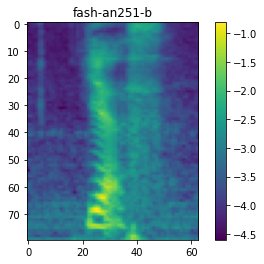

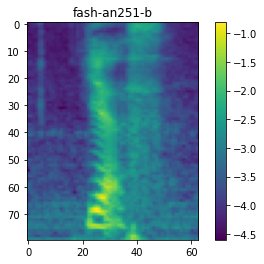

In [12]:
import kaldiio
import matplotlib.pyplot as plt

# load scp file
scp_dict = kaldiio.load_scp("fbank/raw_fbank_train.1.scp")
for key in scp_dict:
    plt.imshow(scp_dict[key].T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break
    
# load ark file
ark_generator = kaldiio.load_ark("fbank/raw_fbank_train.1.ark")
for key, array in ark_generator:
    plt.imshow(array.T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break

After raw mel-spectrogram extraction, some files are added in **data/train/**.  
**feats.scp** is concatenated scp file of **fbank/raw_fbank_train.{1..N}.scp**.  
**utt2num_frames** has the number of feature frames of each `<utt_id>`.

In [13]:
!ls data/train
!head -n 3 data/train/feats.scp data/train/utt2num_frames

feats.scp  filetype  spk2utt  text  utt2num_frames  utt2spk  wav.scp
==> data/train/feats.scp <==
fash-an251-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:13
fash-an253-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:5727
fash-an254-b /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:9921

==> data/train/utt2num_frames <==
fash-an251-b 63
fash-an253-b 44
fash-an254-b 57


And **data/train/** directory is split into two directory:
- **data/train_nodev/**: data directory for training
- **data/train_dev/**: data directory for validation


In [14]:
!ls data
!ls data/train_*

test  train  train_dev	train_nodev
data/train_dev:
feats.scp  spk2utt  text  utt2num_frames  utt2spk  wav.scp

data/train_nodev:
cmvn.ark  feats.scp  spk2utt  text  utt2num_frames  utt2spk  wav.scp


You can find **cmvn.ark** in **data/train_nodev**, which is the calculated statistics file.  
This file also can be loaded in python via kaldiio.


In [15]:
# load cmvn.ark file (Be careful not load_ark, but load_mat)
cmvn = kaldiio.load_mat("data/train_nodev/cmvn.ark")

# cmvn consists of mean and variance, the last dimension of mean represents the number of frames.
print("cmvn shape = "+ str(cmvn.shape))

# calculate mean and variance
mu = cmvn[0, :-1] / cmvn[0, -1]
var = cmvn[1, :-1] / cmvn[0, -1]

# show mean
print("mean = " + str(mu))
print("variance = " + str(var))

cmvn shape = (2, 81)
mean = [-2.3015277 -2.1957324 -1.965476  -1.9376634 -1.763314  -1.6846671
 -1.7875645 -1.9486219 -1.9248271 -1.8872184 -1.9270604 -1.991474
 -1.977873  -2.09246   -2.1971824 -2.2099178 -2.3019783 -2.2964242
 -2.32575   -2.3705876 -2.40271   -2.4498029 -2.43      -2.4660358
 -2.5255733 -2.538611  -2.582323  -2.5250688 -2.6118424 -2.6324549
 -2.6633208 -2.6720283 -2.6356306 -2.6361263 -2.6829062 -2.691491
 -2.694131  -2.675015  -2.673414  -2.665589  -2.6630545 -2.6658235
 -2.657909  -2.6691165 -2.6635575 -2.6643655 -2.6674545 -2.6618829
 -2.660625  -2.657067  -2.6489155 -2.6527998 -2.6650834 -2.6781523
 -2.6988668 -2.7085893 -2.7201533 -2.7215233 -2.7254078 -2.7388637
 -2.7713299 -2.8122766 -2.8621979 -2.911358  -2.9572158 -3.0068166
 -3.0537202 -3.1046875 -3.1606045 -3.2164888 -3.2550602 -3.2886407
 -3.3207698 -3.3445303 -3.3530543 -3.3561647 -3.357716  -3.3631625
 -3.307748  -3.2325494]
variance = [ 5.4785123  5.194147   4.653285   4.3896008  3.6336281  3.4551063
 

Normalzed features for training, validation and evaluation set are dumped in **dump/{train_nodev,train_dev,test}/**.  
There ark and scp can be loaded as the same as the above procedure.



In [16]:
!ls dump/*

dump/test:
feats.1.ark  feats.2.ark  feats.3.ark  feats.4.ark  feats.scp  utt2num_frames
feats.1.scp  feats.2.scp  feats.3.scp  feats.4.scp  filetype

dump/train_dev:
feats.1.ark  feats.2.ark  feats.3.ark  feats.4.ark  feats.scp  utt2num_frames
feats.1.scp  feats.2.scp  feats.3.scp  feats.4.scp  filetype

dump/train_nodev:
feats.1.ark  feats.2.ark  feats.3.ark  feats.4.ark  feats.scp  utt2num_frames
feats.1.scp  feats.2.scp  feats.3.scp  feats.4.scp  filetype


### Stage 2: Dictionary and json preparation

This stage creates dictrionary from **data/train_nodev/text** and makes json file for training.

In [17]:
!./run.sh --stage 2 --stop_stage 2

dictionary: data/lang_1char/train_nodev_units.txt
stage 2: Dictionary and Json Data Preparation
28 data/lang_1char/train_nodev_units.txt
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/train_nodev/feats.scp data/train_nodev data/lang_1char/train_nodev_units.txt
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/train_nodev/feats.scp data/train_nodev/tmp-aOjKO/input_1/shape.scp
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/train_dev/feats.scp data/train_dev data/lang_1char/train_nodev_units.txt
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/train_dev/feats.scp data/train_dev/tmp-2qsYf/input_1/shape.scp
/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/test/feats.scp data/test dat

Dictrionary file will be created in **data/lang_1char/**.  
Dictionary file consists of `<token>` `<token index>`.  
Here, `<token index>` starts from 1 because 0 is used as padding index.


In [18]:
!ls data
!cat data/lang_1char/train_nodev_units.txt

lang_1char  test  train  train_dev  train_nodev
<unk> 1
<space> 2
A 3
B 4
C 5
D 6
E 7
F 8
G 9
H 10
I 11
J 12
K 13
L 14
M 15
N 16
O 17
P 18
Q 19
R 20
S 21
T 22
U 23
V 24
W 25
X 26
Y 27
Z 28


Json file will be created for training / validation /evaludation sets and they are saved as **dump/{train_nodev,train_dev,test}/data.json**.

In [19]:
!ls dump/*/*.json

dump/test/data.json  dump/train_dev/data.json  dump/train_nodev/data.json


Each json file contains all of the information in the data directory.

In [20]:
!head -n 27 dump/train_nodev/data.json

{
    "utts": {
        "fash-an251-b": {
            "input": [
                {
                    "feat": "/mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/dump/train_nodev/feats.1.ark:13",
                    "name": "input1",
                    "shape": [
                        63,
                        80
                    ]
                }
            ],
            "output": [
                {
                    "name": "target1",
                    "shape": [
                        3,
                        30
                    ],
                    "text": "YES",
                    "token": "Y E S",
                    "tokenid": "27 7 21"
                }
            ],
            "utt2spk": "fash"
        },


- "shape": Shape of the input or output sequence. Here input shape [63, 80] represents the number of frames = 63 and the dimension of mel-spectrogram = 80.
- "text": Original transcription.
- "token": Token sequence of original transcription.
- "tokenid" Token id sequence of original transcription, which is converted using the dictionary.

Now ready to start training!

### Stage 3: Network training

This stage performs training of the network.  
Network training configurations are written as **.yaml** format file.  
Let us check the default cofiguration **conf/train_pytroch_tacotron2.yaml**.

In [21]:
!cat conf/train_pytorch_tacotron2.yaml

# This is the basic tactron2 training settting

# encoder related
embed-dim: 512
elayers: 1
eunits: 512
econv-layers: 3 # if set 0, no conv layer is used
econv-chans: 512
econv-filts: 5

# decoder related
dlayers: 2
dunits: 1024
prenet-layers: 2  # if set 0, no prenet is used
prenet-units: 256
postnet-layers: 5 # if set 0, no postnet is used
postnet-chans: 512
postnet-filts: 5

# attention related
atype: location
adim: 128
aconv-chans: 32
aconv-filts: 15      # resulting in filter-size = aconv-filts * 2 + 1
cumulate-att-w: true # whether to cumulate attetion weight
use-batch-norm: true # whether to use batch normalization in conv layer
use-concate: true    # whether to concatenate encoder embedding with decoder lstm outputs
use-residual: false  # whether to use residual connection in encoder convolution
use-masking: true    # whether to mask the padded part in loss calculation
bce-pos-weight: 1.0  # weight for positive samples of stop token in cross-entropy calculation
reduction-factor

You can modify this configuration file to change the hyperparameters.  
Here, let's change the number of epochs for this demonstration.

In [22]:
# TODO(kan-bayashi): Change here to use change_yaml.py
!cat conf/train_pytorch_tacotron2.yaml | sed -e "s/epochs: 50/epochs: 3/g" > conf/train_pytorch_tacotron2_sample.yaml
!cat conf/train_pytorch_tacotron2_sample.yaml

# This is the basic tactron2 training settting

# encoder related
embed-dim: 512
elayers: 1
eunits: 512
econv-layers: 3 # if set 0, no conv layer is used
econv-chans: 512
econv-filts: 5

# decoder related
dlayers: 2
dunits: 1024
prenet-layers: 2  # if set 0, no prenet is used
prenet-units: 256
postnet-layers: 5 # if set 0, no postnet is used
postnet-chans: 512
postnet-filts: 5

# attention related
atype: location
adim: 128
aconv-chans: 32
aconv-filts: 15      # resulting in filter-size = aconv-filts * 2 + 1
cumulate-att-w: true # whether to cumulate attetion weight
use-batch-norm: true # whether to use batch normalization in conv layer
use-concate: true    # whether to concatenate encoder embedding with decoder lstm outputs
use-residual: false  # whether to use residual connection in encoder convolution
use-masking: true    # whether to mask the padded part in loss calculation
bce-pos-weight: 1.0  # weight for positive samples of stop token in cross-entropy calculation
reduction-factor

Let's train the network.  
You can specify the config file via **--train_config** option.
It takes several minutes.


In [23]:
!./run.sh --stage 3 --stop_stage 3 --train_config conf/train_pytorch_tacotron2_sample.yaml --verbose 1

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: Text-to-speech model training


You can see the training log in `exp/train_*/train.log`.

The models are saved in `exp/train_*/results/` directory.

In [24]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/att_ws

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results:
all_loss.png  l1_loss.png  model.loss.best  snapshot.ep.2
att_ws	      loss.png	   mse_loss.png     snapshot.ep.3
bce_loss.png  model.json   snapshot.ep.1

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/att_ws:
fash-an251-b.ep.1.npy  fash-an253-b.ep.3.npy  fash-an255-b.ep.2.npy
fash-an251-b.ep.1.png  fash-an253-b.ep.3.png  fash-an255-b.ep.2.png
fash-an251-b.ep.2.npy  fash-an254-b.ep.1.npy  fash-an255-b.ep.3.npy
fash-an251-b.ep.2.png  fash-an254-b.ep.1.png  fash-an255-b.ep.3.png
fash-an251-b.ep.3.npy  fash-an254-b.ep.2.npy  fash-cen1-b.ep.1.npy
fash-an251-b.ep.3.png  fash-an254-b.ep.2.png  fash-cen1-b.ep.1.png
fash-an253-b.ep.1.npy  fash-an254-b.ep.3.npy  fash-cen1-b.ep.2.npy
fash-an253-b.ep.1.png  fash-an254-b.ep.3.png  fash-cen1-b.ep.2.png
fash-an253-b.ep.2.npy  fash-an255-b.ep.1.npy  fash-cen1-b.ep.3.npy
fash-an253-b.ep.2.png  fash-an255-b.ep.1.png  fash-cen1-b.ep.3.png


`exp/train_*/results/*.png` are the figures of training curve.

all loss curve


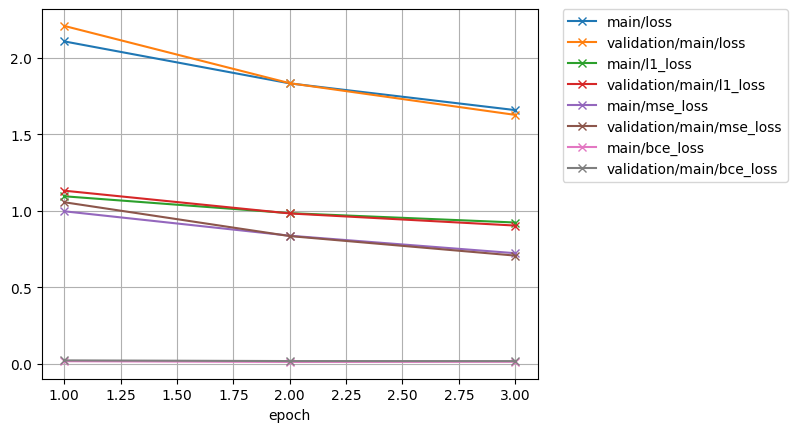

l1 loss curve


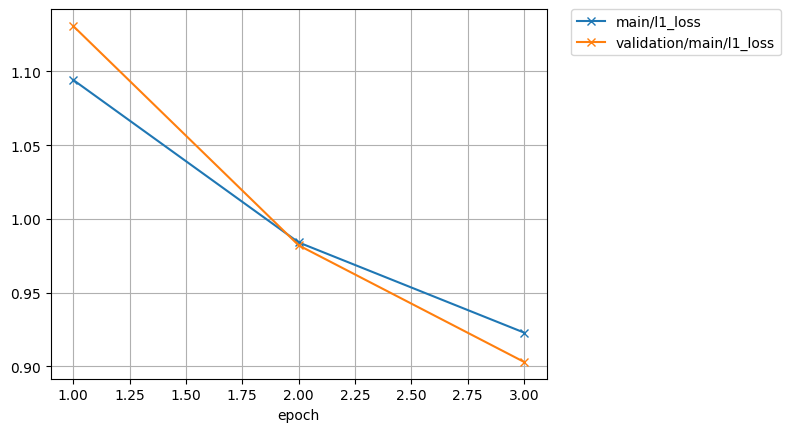

mse loss curve


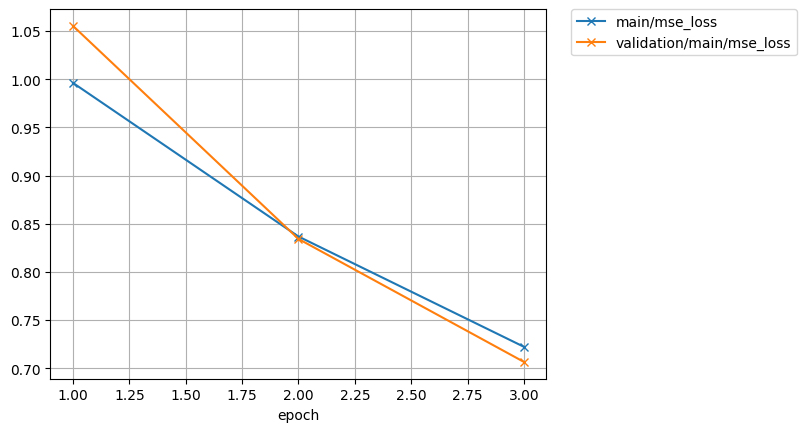

bce loss curve


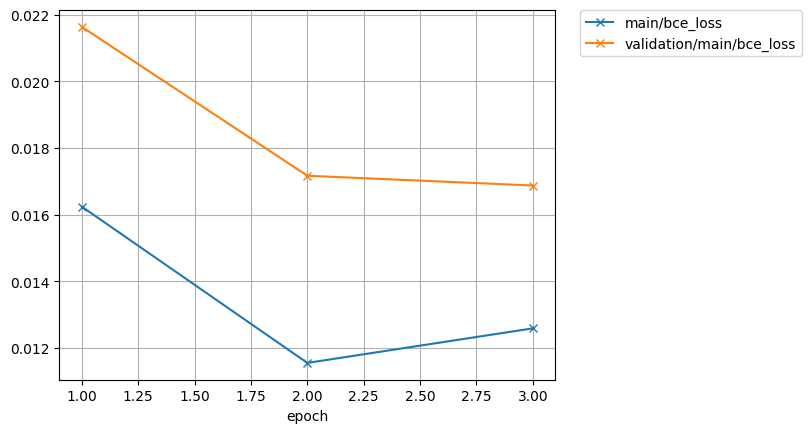

In [25]:
from IPython.display import Image, display_png
print("all loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/all_loss.png"))
print("l1 loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/l1_loss.png"))
print("mse loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/mse_loss.png"))
print("bce loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/bce_loss.png"))

`exp/train_*/results/att_ws/.png` are the figures of attention weights in each epoch.

Attention weights of initial epoch


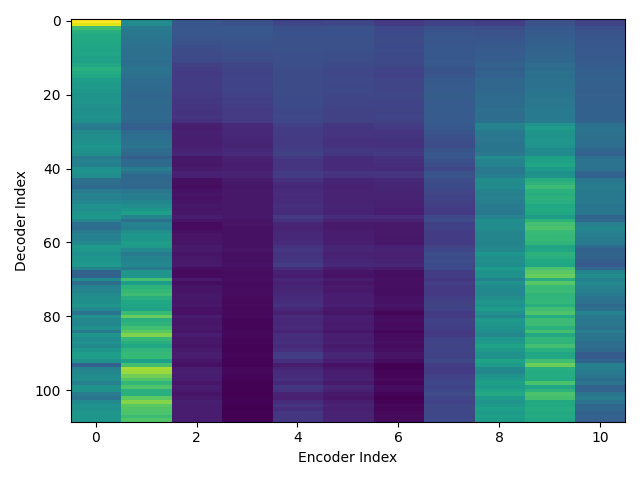

In [26]:
print("Attention weights of initial epoch")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/att_ws/fash-cen1-b.ep.1.png"))

`exp/train_*/results/model.loss.best` contains only the model parameters.  
On the other hand, `exp/train_*/results/snapshot` contains the model parameters, optimizer states, and iterator states.  
So you can restart from the training by specifying the snapshot file with **--resume** option.


In [27]:
# resume training from snapshot.ep.2
!./run.sh --stage 3 --stop_stage 3 --train_config conf/train_pytorch_tacotron2_sample.yaml --resume exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/snapshot.ep.2 --verbose 1

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: Text-to-speech model training


In [28]:
!cat exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/train.log

# tts_train.py --backend pytorch --ngpu 1 --minibatches 0 --outdir exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results --tensorboard-dir tensorboard/train_nodev_pytorch_train_pytorch_tacotron2_sample --verbose 1 --seed 1 --resume exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/snapshot.ep.2 --train-json dump/train_nodev/data.json --valid-json dump/train_dev/data.json --config conf/train_pytorch_tacotron2_sample.yaml 
# Started at Sat May 30 14:25:53 IST 2020
#
2020-05-30 14:25:55,413 (tts_train:339) INFO: ngpu: 1
2020-05-30 14:25:55,413 (tts_train:342) INFO: random seed = 1
2020-05-30 14:25:55,473 (deterministic_utils:26) INFO: torch type check is disabled
2020-05-30 14:25:55,495 (tts:279) INFO: #input dims : 30
2020-05-30 14:25:55,495 (tts:280) INFO: #output dims: 80
2020-05-30 14:25:55,495 (tts:297) INFO: writing a model config file toexp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/model.json
2020-05-30 14:25:55,496 (tts:304) INFO: ARGS: accum

Also, we support tensorboard.  
You can see the training log through tensorboard.

In [29]:
%load_ext tensorboard
%tensorboard --logdir tensorboard/train_nodev_pytorch_train_pytorch_tacotron2_sample/

### Stage 4: Network decoding

This stage performs decoding using the trained model to generate mel-spectrogram from a given text.  


In [30]:
!./run.sh --stage 4 --stop_stage 4 --nj 8 --train_config conf/train_pytorch_tacotron2_sample.yaml 

dictionary: data/lang_1char/train_nodev_units.txt
stage 4: Decoding
2020-05-30 14:26:46,359 (splitjson:43) INFO: /home/syzygianinfern0/miniconda3/envs/intern/bin/python3 /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/splitjson.py --parts 8 exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/train_dev/data.json
2020-05-30 14:26:46,361 (splitjson:55) INFO: number of utterances = 100
2020-05-30 14:26:46,384 (splitjson:43) INFO: /home/syzygianinfern0/miniconda3/envs/intern/bin/python3 /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/splitjson.py --parts 8 exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/test/data.json
2020-05-30 14:26:46,386 (splitjson:55) INFO: number of utterances = 130


Generated features are saved as ark/scp format.

In [31]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/*

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/test:
att_ws	     feats.2.ark  feats.4.ark  feats.6.ark  feats.8.ark  probs
data.json    feats.2.scp  feats.4.scp  feats.6.scp  feats.8.scp  split8utt
feats.1.ark  feats.3.ark  feats.5.ark  feats.7.ark  feats.scp
feats.1.scp  feats.3.scp  feats.5.scp  feats.7.scp  log

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/train_dev:
att_ws	     feats.2.ark  feats.4.ark  feats.6.ark  feats.8.ark  probs
data.json    feats.2.scp  feats.4.scp  feats.6.scp  feats.8.scp  split8utt
feats.1.ark  feats.3.ark  feats.5.ark  feats.7.ark  feats.scp
feats.1.scp  feats.3.scp  feats.5.scp  feats.7.scp  log


We can specify the model or snapshot to be used for decoding via **--model**.   

In [32]:
!./run.sh --stage 4 --stop_stage 4 --nj 8 --train_config conf/train_pytorch_tacotron2_sample.yaml --model snapshot.ep.2

dictionary: data/lang_1char/train_nodev_units.txt
stage 4: Decoding
2020-05-30 14:28:57,388 (splitjson:43) INFO: /home/syzygianinfern0/miniconda3/envs/intern/bin/python3 /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/splitjson.py --parts 8 exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_snapshot.ep.2_decode/test/data.json
2020-05-30 14:28:57,389 (splitjson:55) INFO: number of utterances = 130
2020-05-30 14:28:57,390 (splitjson:43) INFO: /home/syzygianinfern0/miniconda3/envs/intern/bin/python3 /mnt/nvme0n1p5/Code/Intern/espnet/egs/an4/tts1/../../../utils/splitjson.py --parts 8 exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_snapshot.ep.2_decode/train_dev/data.json
2020-05-30 14:28:57,391 (splitjson:55) INFO: number of utterances = 100


In [33]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_snapshot.ep.2_decode/*

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_snapshot.ep.2_decode/test:
att_ws	     feats.2.ark  feats.4.ark  feats.6.ark  feats.8.ark  probs
data.json    feats.2.scp  feats.4.scp  feats.6.scp  feats.8.scp  split8utt
feats.1.ark  feats.3.ark  feats.5.ark  feats.7.ark  feats.scp
feats.1.scp  feats.3.scp  feats.5.scp  feats.7.scp  log

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_snapshot.ep.2_decode/train_dev:
att_ws	     feats.2.ark  feats.4.ark  feats.6.ark  feats.8.ark  probs
data.json    feats.2.scp  feats.4.scp  feats.6.scp  feats.8.scp  split8utt
feats.1.ark  feats.3.ark  feats.5.ark  feats.7.ark  feats.scp
feats.1.scp  feats.3.scp  feats.5.scp  feats.7.scp  log


### Stage 5: Waveform synthesis

Finally, in this stage, we generate waveform using Grrifin-Lim algorithm.  
First, we perform de-normalization to convert the generated mel-spectrogram into the original scale.  
Then we apply Grrifin-Lim algorithm to restore phase components and apply inverse STFT to generate waveforms.

In [34]:
!./run.sh --stage 5 --stop_stage 5 --nj 8 --train_config conf/train_pytorch_tacotron2_sample.yaml --griffin_lim_iters 50

dictionary: data/lang_1char/train_nodev_units.txt
stage 5: Synthesis
apply-cmvn --norm-vars=true --reverse=true data/train_nodev/cmvn.ark scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/test/feats.scp ark,scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/test/feats.ark,exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/test/feats.scp 
apply-cmvn --norm-vars=true --reverse=true data/train_nodev/cmvn.ark scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/train_dev/feats.scp ark,scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/train_dev/feats.ark,exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/train_dev/feats.scp 
LOG (apply-cmvn[5.5.428~1-29b3]:main():apply-cmvn.cc:159) Applied cepstral mean and variance normalization to 100 utte

Generated wav files are saved in `exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/*/wav`

In [35]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/*/wav

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/test/wav:
fcaw-an406-b.wav  fvap-cen3-b.wav    menk-an422-b.wav  mjgm-cen4-b.wav
fcaw-an407-b.wav  fvap-cen4-b.wav    menk-an423-b.wav  mjgm-cen5-b.wav
fcaw-an408-b.wav  fvap-cen5-b.wav    menk-an424-b.wav  mjgm-cen6-b.wav
fcaw-an409-b.wav  fvap-cen6-b.wav    menk-an425-b.wav  mjgm-cen7-b.wav
fcaw-an410-b.wav  fvap-cen7-b.wav    menk-cen1-b.wav   mjgm-cen8-b.wav
fcaw-cen1-b.wav   fvap-cen8-b.wav    menk-cen2-b.wav   mjwl-an391-b.wav
fcaw-cen2-b.wav   marh-an431-b.wav   menk-cen3-b.wav   mjwl-an392-b.wav
fcaw-cen3-b.wav   marh-an432-b.wav   menk-cen4-b.wav   mjwl-an393-b.wav
fcaw-cen4-b.wav   marh-an433-b.wav   menk-cen5-b.wav   mjwl-an394-b.wav
fcaw-cen5-b.wav   marh-an434-b.wav   menk-cen6-b.wav   mjwl-an395-b.wav
fcaw-cen6-b.wav   marh-an435-b.wav   menk-cen7-b.wav   mjwl-cen1-b.wav
fcaw-cen7-b.wav   marh-cen1-b.wav    menk-cen8-b.wav   mjwl-cen2-b.wav
fcaw-cen8-b.wav   marh-cen2-b.wav    mir

In [36]:
!tree -L 3

.
├── cmd.sh
├── conf
│   ├── decode.yaml
│   ├── gpu.conf
│   ├── slurm.conf
│   ├── train_pytorch_tacotron2_sample.yaml
│   └── train_pytorch_tacotron2.yaml
├── data
│   ├── lang_1char
│   │   └── train_nodev_units.txt
│   ├── test
│   │   ├── feats.scp
│   │   ├── filetype
│   │   ├── spk2utt
│   │   ├── text
│   │   ├── utt2num_frames
│   │   ├── utt2spk
│   │   └── wav.scp
│   ├── train
│   │   ├── feats.scp
│   │   ├── filetype
│   │   ├── spk2utt
│   │   ├── text
│   │   ├── utt2num_frames
│   │   ├── utt2spk
│   │   └── wav.scp
│   ├── train_dev
│   │   ├── feats.scp
│   │   ├── spk2utt
│   │   ├── text
│   │   ├── utt2num_frames
│   │   ├── utt2spk
│   │   └── wav.scp
│   └── train_nodev
│       ├── cmvn.ark
│       ├── feats.scp
│       ├── spk2utt
│       ├── text
│       ├── utt2num_frames
│       ├── utt2spk
│       └── wav.scp
├── downloads
│   ├── an4
│   │   ├── etc
│   │   ├── LICENSE
│   │   ├── README
│   │   └── wav
│   └── an4_sphere.tar.gz
├── dump
│   ├── test
│ 

## NEXT step

- Try pretrained model to generate speech.
- Try a large single speaker dataset recipe **egs/ljspeech/tts1**.
- Try a large multi-speaker recipe **egs/libritts/tts1**.
- Make the original recipe using your own dataset.